## CNN inference example

the script was also tested in Czech Dataset 

In [3]:
import os
os.chdir('toufikshit/pycomlink/')
print("Current working directory:", os.getcwd())

Current working directory: /home/jovyan/toufikshit/pycomlink


In [2]:
os.chdir('/home/jovyan/')
print("Current working directory:", os.getcwd())

Current working directory: /home/jovyan


In [4]:
!pip install .

Processing /home/jovyan/toufikshit/pycomlink
  Preparing metadata (setup.py) ... done
  Created wheel for pycomlink: filename=pycomlink-0.4.1-py3-none-any.whl size=25553679 sha256=658e4c258f8f2f01d59697c2b89328e9cf6311c3c3d83de0842b1fcadad2b315
  Stored in directory: /tmp/pip-ephem-wheel-cache-n51elzj7/wheels/f2/98/aa/1991355548c9b56d826d8ecc06a2c2fabd6528d21c8a38b60e
Successfully built pycomlink
  Attempting uninstall: pycomlink
    Found existing installation: pycomlink 0.4.1
    Uninstalling pycomlink-0.4.1:
      Successfully uninstalled pycomlink-0.4.1


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
import pycomlink as pycml
# this is how we import the submodel 
from pycomlink.processing.tensorflow_utils import cnn

2025-09-24 10:23:23.144364: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Load data

data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

# select 3 different CMLs to study
cmls = cmls.isel(cml_id = [0, 10, 370])

# Remove outliers, compute tl and interpolate missing values
cmls['tsl'] = cmls.tsl.where(cmls.tsl != 255.0)
cmls['rsl'] = cmls.rsl.where(cmls.rsl != -99.9)
cmls['tl'] = cmls.tsl - cmls.rsl # calculate total loss (previous TRSL)
cmls['tl'] = cmls.tl.interpolate_na(dim='time', method='linear', max_gap='5min')

In [7]:
cmls["tl1"] = cmls["tl"].sel(channel_id = 'channel_1')
cmls["tl2"] = cmls["tl"].sel(channel_id = 'channel_2')

__Load DL model and set up a path for model weights__

In [8]:
json_url = "https://github.com/toufikshit/pycomlink/releases/download/v1/CNN__model_v0_cz.json"
weights_url = "https://github.com/toufikshit/pycomlink/releases/download/v1/CNN__model_v0_cz.weights.h5"

json_path, weights_path = cnn.resolve_model_paths(
    json_url, weights_url, cache_dir="model_cnn"
)

# Load and run the model
model = cnn.load_model_from_local(json_path, weights_path, lr=0.05)


[🗂️] Using model cache directory: /home/jovyan/toufikshit/pycomlink/model_cnn
[→] Using cached file: /home/jovyan/toufikshit/pycomlink/model_cnn/CNN__model_v0_cz.json
[→] Using cached file: /home/jovyan/toufikshit/pycomlink/model_cnn/CNN__model_v0_cz.weights.h5
[✓] Model loaded from architecture + weights (RESTORE mode).


2025-09-24 10:23:30.744138: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/opt/conda/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [9]:
cmls

<xarray.Dataset> Size: 3MB
Dimensions:           (channel_id: 2, cml_id: 3, time: 15840)
Coordinates:
  * time              (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T2...
  * cml_id            (cml_id) <U3 36B '0' '10' '370'
    length            (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude   (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude  (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude   (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude  (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id        (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency         (cml_id, channel_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization      (cml_id, channel_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'
Data variables:
    rsl               (channel_id, cml_id, time) float64 760kB -47.0 ... -44.2
    tsl               (channel_id, cml_id, time) float64 760kB 13.0 ... 16.0
    tl                (channel_id, cml_id, time) float64 760kB 60.0 ... 60.2
    tl1               (cml_id, time) float64 380kB 60.0 59.0 58.7 ... 57.0 57.0
    tl2               (cml_id, time) float64 380kB 55.7 55.7 56.0 ... 60.2 60.2

In [10]:
ids= cmls.cml_id.values
X, ids = cnn.create_samples(
    ds=cmls,
    cml_ids=ids,
    input_vars=["tl1","tl2"],  
    seq_len=180,
)


In [12]:
X_train_scaled,  scalers = cnn.scale_features(
    input_seq=X, # this should be input_seq
    input_vars=["tl1","tl2"]) # input var 



## CNN inference 

In [13]:
y_prob, y_pred = cnn.run_inference(model=model,
    model_input=X_train_scaled, 
    threshold=0.1,
    batch_size=32  
)

1457/1457 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
[✓] Prediction Completed — 46595 Samples.


##  Storing the prediction in the orignal dataset 

In [14]:

results = cnn.store_predictions(
    merged=cmls,
    model_prob=y_prob, #model_prob
    cml_ids=ids,
    model_name="TL_Model"
)


Storing predictions (TL_Model): 100%|██████████| 3/3 [00:00<00:00, 760.80CML/s]


In [15]:
results

<xarray.Dataset> Size: 3MB
Dimensions:            (channel_id: 2, cml_id: 3, time: 15840)
Coordinates:
  * time               (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T...
  * cml_id             (cml_id) <U3 36B '0' '10' '370'
    length             (cml_id) float64 24B 6.179 2.862 5.721
    site_a_latitude    (cml_id) float64 24B 58.26 58.05 57.89
    site_a_longitude   (cml_id) float64 24B 1.388 1.34 1.292
    site_b_latitude    (cml_id) float64 24B 58.25 58.04 57.83
    site_b_longitude   (cml_id) float64 24B 1.304 1.378 1.298
  * channel_id         (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency          (cml_id, channel_id) float64 48B 2.491e+10 ... 2.486e+10
    polarization       (cml_id, channel_id) <U1 24B 'V' 'V' 'V' 'V' 'V' 'V'
Data variables:
    rsl                (channel_id, cml_id, time) float64 760kB -47.0 ... -44.2
    tsl                (channel_id, cml_id, time) float64 760kB 13.0 ... 16.0
    tl                 (channel_id, cml_id, time) float64 760kB 60.0 ... 60.2
    tl1                (cml_id, time) float64 380kB 60.0 59.0 58.7 ... 57.0 57.0
    tl2                (cml_id, time) float64 380kB 55.7 55.7 56.0 ... 60.2 60.2
    cnn_prob_TL_Model  (time, cml_id) float32 190kB 0.007466 0.00388 ... nan nan

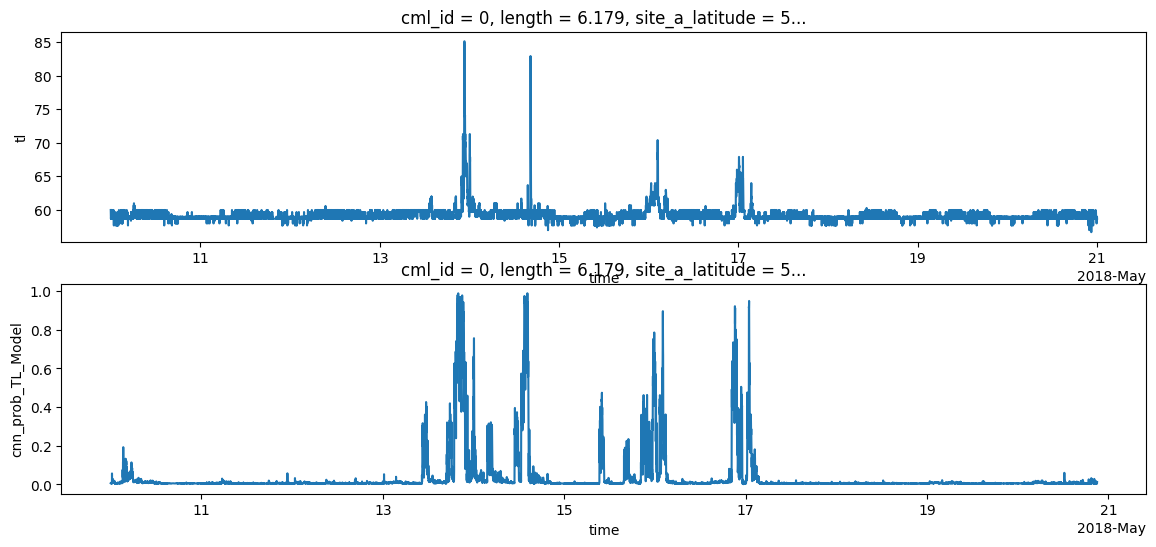

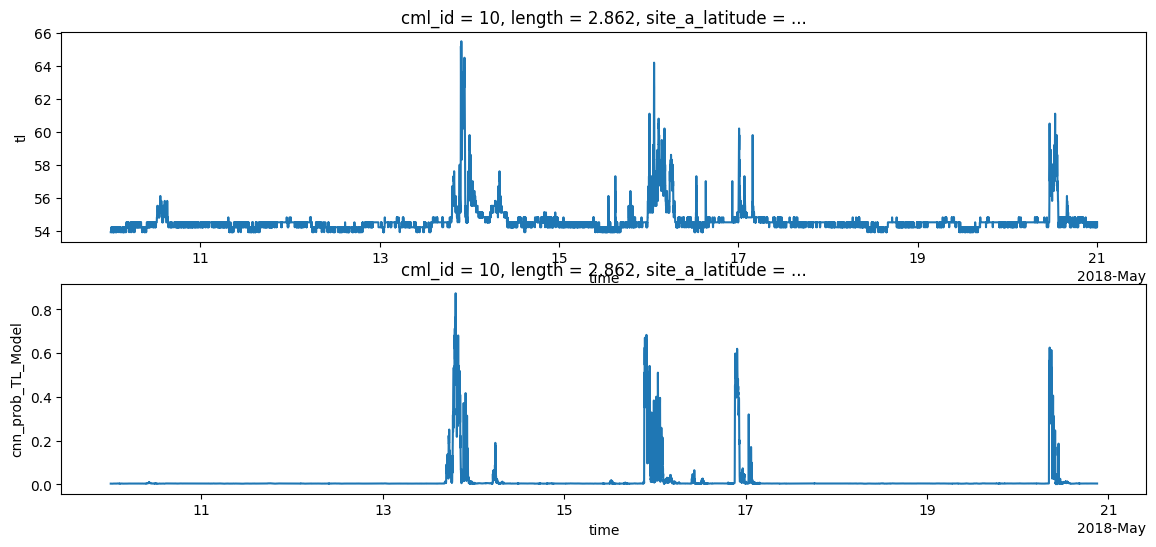

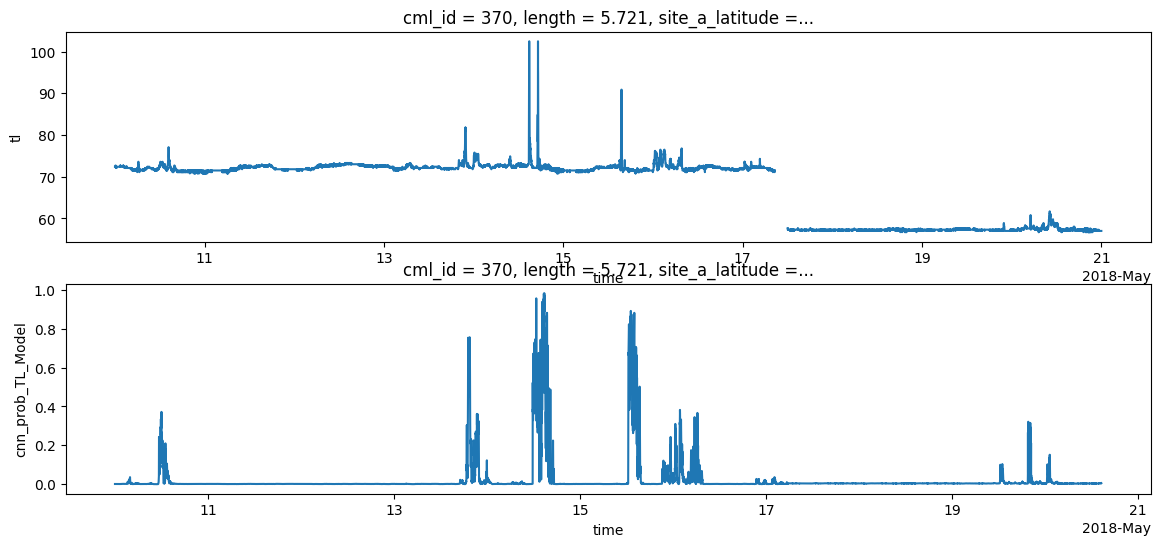

In [16]:
for cml_id in cmls.cml_id.data:
    fig, axs = plt.subplots(2, 1, figsize=(14, 6))
    results.tl.sel(cml_id=cml_id).isel(channel_id=0).plot.line(x='time', ax=axs[0])
    results.cnn_prob_TL_Model.sel(cml_id=cml_id).plot.line(x='time', ax=axs[1])
    
